In [11]:
import os, sys, shutil, subprocess, textwrap

# --- Helper: run a command and print output nicely ---
def run(cmd):
    print(">>", " ".join(cmd))
    p = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    print(p.stdout)
    return p.returncode, p.stdout

# 1) Ensure Python graphviz package exists (safe even if already installed)
run([sys.executable, "-m", "pip", "install", "-q", "graphviz"])

# 2) Install Graphviz *binaries* (dot) using conda (no Homebrew needed)
# Use your Anaconda conda directly (works even if conda isn't on PATH)
conda_exe = "/opt/anaconda3/bin/conda"
if not os.path.exists(conda_exe):
    raise FileNotFoundError(
        "Could not find conda at /opt/anaconda3/bin/conda. "
        "If your Anaconda is elsewhere, update `conda_exe` in this cell."
    )

# Install graphviz binaries from conda-forge (the missing 'dot')
run([conda_exe, "install", "-y", "-c", "conda-forge", "graphviz"])

# 3) Force PATH so this Jupyter kernel can find dot (common Anaconda location)
for p in ["/opt/anaconda3/bin", "/usr/local/bin", "/opt/homebrew/bin"]:
    if os.path.isdir(p) and p not in os.environ["PATH"]:
        os.environ["PATH"] = p + ":" + os.environ["PATH"]

# 4) Verify dot is now visible
dot_path = shutil.which("dot")
print("dot path:", dot_path)
if dot_path is None:
    raise RuntimeError(
        "Graphviz 'dot' still not found after conda install.\n"
        "Restart the kernel (Kernel -> Restart) and run this cell again.\n"
        "If it still fails, your notebook kernel is likely using a different conda environment."
    )

# Print version as final confirmation
run(["dot", "-V"])
print("✅ Graphviz is installed and dot is available in this notebook.")


>> /opt/anaconda3/bin/python -m pip install -q graphviz

>> /opt/anaconda3/bin/conda install -y -c conda-forge graphviz
Jupyter detected...
2 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       hcb7b3dd_1         364 KB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-pro-2.038|       h77eed37_0         684 KB  conda-forge
    font-ttf-ubuntu-0.83       |       h77eed37_3         1.5 MB  conda-forge
    fonts-conda-ecosystem-1    |                0           4 KB  conda-f

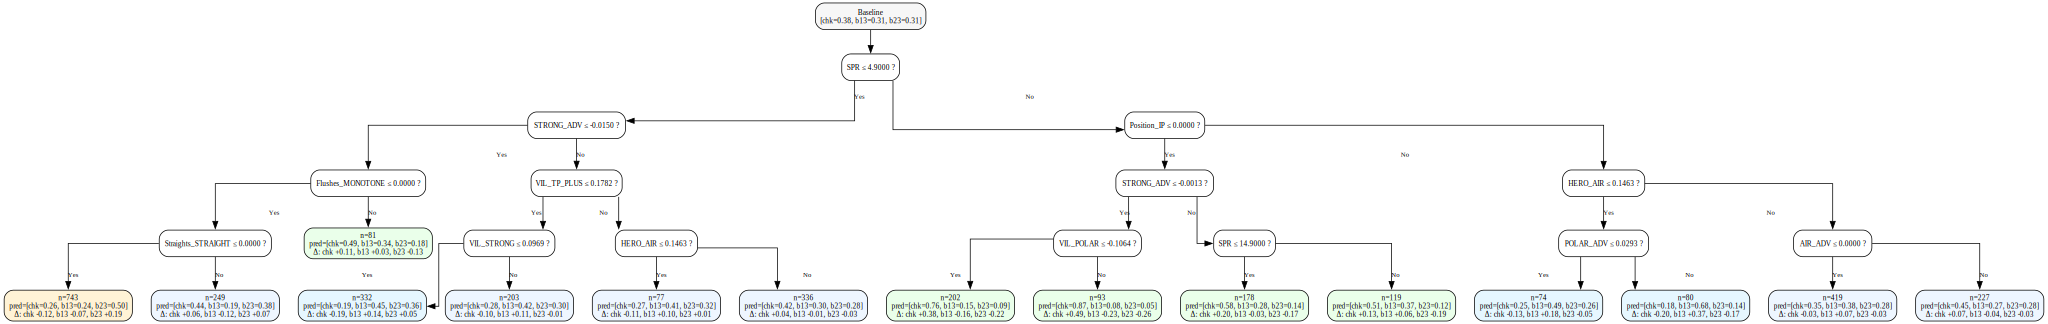

Saved: BornAgainTree.png


In [14]:
from graphviz import Digraph
from IPython.display import display

BASELINE = [0.38, 0.31, 0.31]  # [check, b13, b23]

def fmt_pred(p):
    return f"[chk={p[0]:.2f}, b13={p[1]:.2f}, b23={p[2]:.2f}]"

def fmt_delta(p, baseline=BASELINE):
    d = [p[i] - baseline[i] for i in range(3)]
    return f"Δ: chk {d[0]:+0.2f}, b13 {d[1]:+0.2f}, b23 {d[2]:+0.2f}"

def leaf_label(n, pred):
    # ONLY: n, pred, delta vs baseline
    return f"n={n}\\npred={fmt_pred(pred)}\\n{fmt_delta(pred)}"

dot = Digraph("BornAgainTree", format="png")
dot.attr(rankdir="TB", splines="ortho", nodesep="0.35", ranksep="0.45")
dot.attr("node", shape="box", style="rounded,filled", fillcolor="white", fontsize="10")
dot.attr("edge", fontsize="9")

# Base node (no "avg solver train + val")
dot.node("BASE", f"Baseline\\n{fmt_pred(BASELINE)}",
         style="rounded,filled", fillcolor="#f7f7f7")

# Root
dot.node("N0", "SPR ≤ 4.9000 ?")
dot.edge("BASE", "N0")

# ---- SPR <= 4.9 ----
dot.node("N1", "STRONG_ADV ≤ -0.0150 ?")
dot.edge("N0", "N1", label="Yes")

dot.node("N2", "Flushes_MONOTONE ≤ 0.0000 ?")
dot.edge("N1", "N2", label="Yes")

dot.node("N3", "Straights_STRAIGHT ≤ 0.0000 ?")
dot.edge("N2", "N3", label="Yes")

dot.node("L743", leaf_label(743, [0.26, 0.24, 0.50]),
         style="rounded,filled", fillcolor="#fff3d6")
dot.edge("N3", "L743", label="Yes")

dot.node("L249", leaf_label(249, [0.44, 0.19, 0.38]),
         style="rounded,filled", fillcolor="#eef6ff")
dot.edge("N3", "L249", label="No")

dot.node("L81", leaf_label(81, [0.49, 0.34, 0.18]),
         style="rounded,filled", fillcolor="#eaffea")
dot.edge("N2", "L81", label="No")

dot.node("N4", "VIL_TP_PLUS ≤ 0.1782 ?")
dot.edge("N1", "N4", label="No")

dot.node("N5", "VIL_STRONG ≤ 0.0969 ?")
dot.edge("N4", "N5", label="Yes")

dot.node("L332", leaf_label(332, [0.19, 0.45, 0.36]),
         style="rounded,filled", fillcolor="#e6f7ff")
dot.edge("N5", "L332", label="Yes")

dot.node("L203", leaf_label(203, [0.28, 0.42, 0.30]),
         style="rounded,filled", fillcolor="#eef6ff")
dot.edge("N5", "L203", label="No")

dot.node("N6", "HERO_AIR ≤ 0.1463 ?")
dot.edge("N4", "N6", label="No")

dot.node("L77", leaf_label(77, [0.27, 0.41, 0.32]),
         style="rounded,filled", fillcolor="#eef6ff")
dot.edge("N6", "L77", label="Yes")

dot.node("L336", leaf_label(336, [0.42, 0.30, 0.28]),
         style="rounded,filled", fillcolor="#eef6ff")
dot.edge("N6", "L336", label="No")

# ---- SPR > 4.9 ----
dot.node("N7", "Position_IP ≤ 0.0000 ?")
dot.edge("N0", "N7", label="No")

dot.node("N8", "STRONG_ADV ≤ -0.0013 ?")
dot.edge("N7", "N8", label="Yes")

dot.node("N9", "VIL_POLAR ≤ -0.1064 ?")
dot.edge("N8", "N9", label="Yes")

dot.node("L202", leaf_label(202, [0.76, 0.15, 0.09]),
         style="rounded,filled", fillcolor="#eaffea")
dot.edge("N9", "L202", label="Yes")

dot.node("L93", leaf_label(93, [0.87, 0.08, 0.05]),
         style="rounded,filled", fillcolor="#eaffea")
dot.edge("N9", "L93", label="No")

dot.node("N10", "SPR ≤ 14.9000 ?")
dot.edge("N8", "N10", label="No")

dot.node("L178", leaf_label(178, [0.58, 0.28, 0.14]),
         style="rounded,filled", fillcolor="#eaffea")
dot.edge("N10", "L178", label="Yes")

dot.node("L119", leaf_label(119, [0.51, 0.37, 0.12]),
         style="rounded,filled", fillcolor="#eaffea")
dot.edge("N10", "L119", label="No")

dot.node("N11", "HERO_AIR ≤ 0.1463 ?")
dot.edge("N7", "N11", label="No")

dot.node("N12", "POLAR_ADV ≤ 0.0293 ?")
dot.edge("N11", "N12", label="Yes")

dot.node("L74", leaf_label(74, [0.25, 0.49, 0.26]),
         style="rounded,filled", fillcolor="#e6f7ff")
dot.edge("N12", "L74", label="Yes")

dot.node("L80", leaf_label(80, [0.18, 0.68, 0.14]),
         style="rounded,filled", fillcolor="#e6f7ff")
dot.edge("N12", "L80", label="No")

dot.node("N13", "AIR_ADV ≤ 0.0000 ?")
dot.edge("N11", "N13", label="No")

dot.node("L419", leaf_label(419, [0.35, 0.38, 0.28]),
         style="rounded,filled", fillcolor="#eef6ff")
dot.edge("N13", "L419", label="Yes")

dot.node("L227", leaf_label(227, [0.45, 0.27, 0.28]),
         style="rounded,filled", fillcolor="#eef6ff")
dot.edge("N13", "L227", label="No")

display(dot)

# Save slide-ready PNG (creates BornAgainTree.png)
dot.render("BornAgainTree", cleanup=True)
print("Saved: BornAgainTree.png")

Matplotlib is building the font cache; this may take a moment.


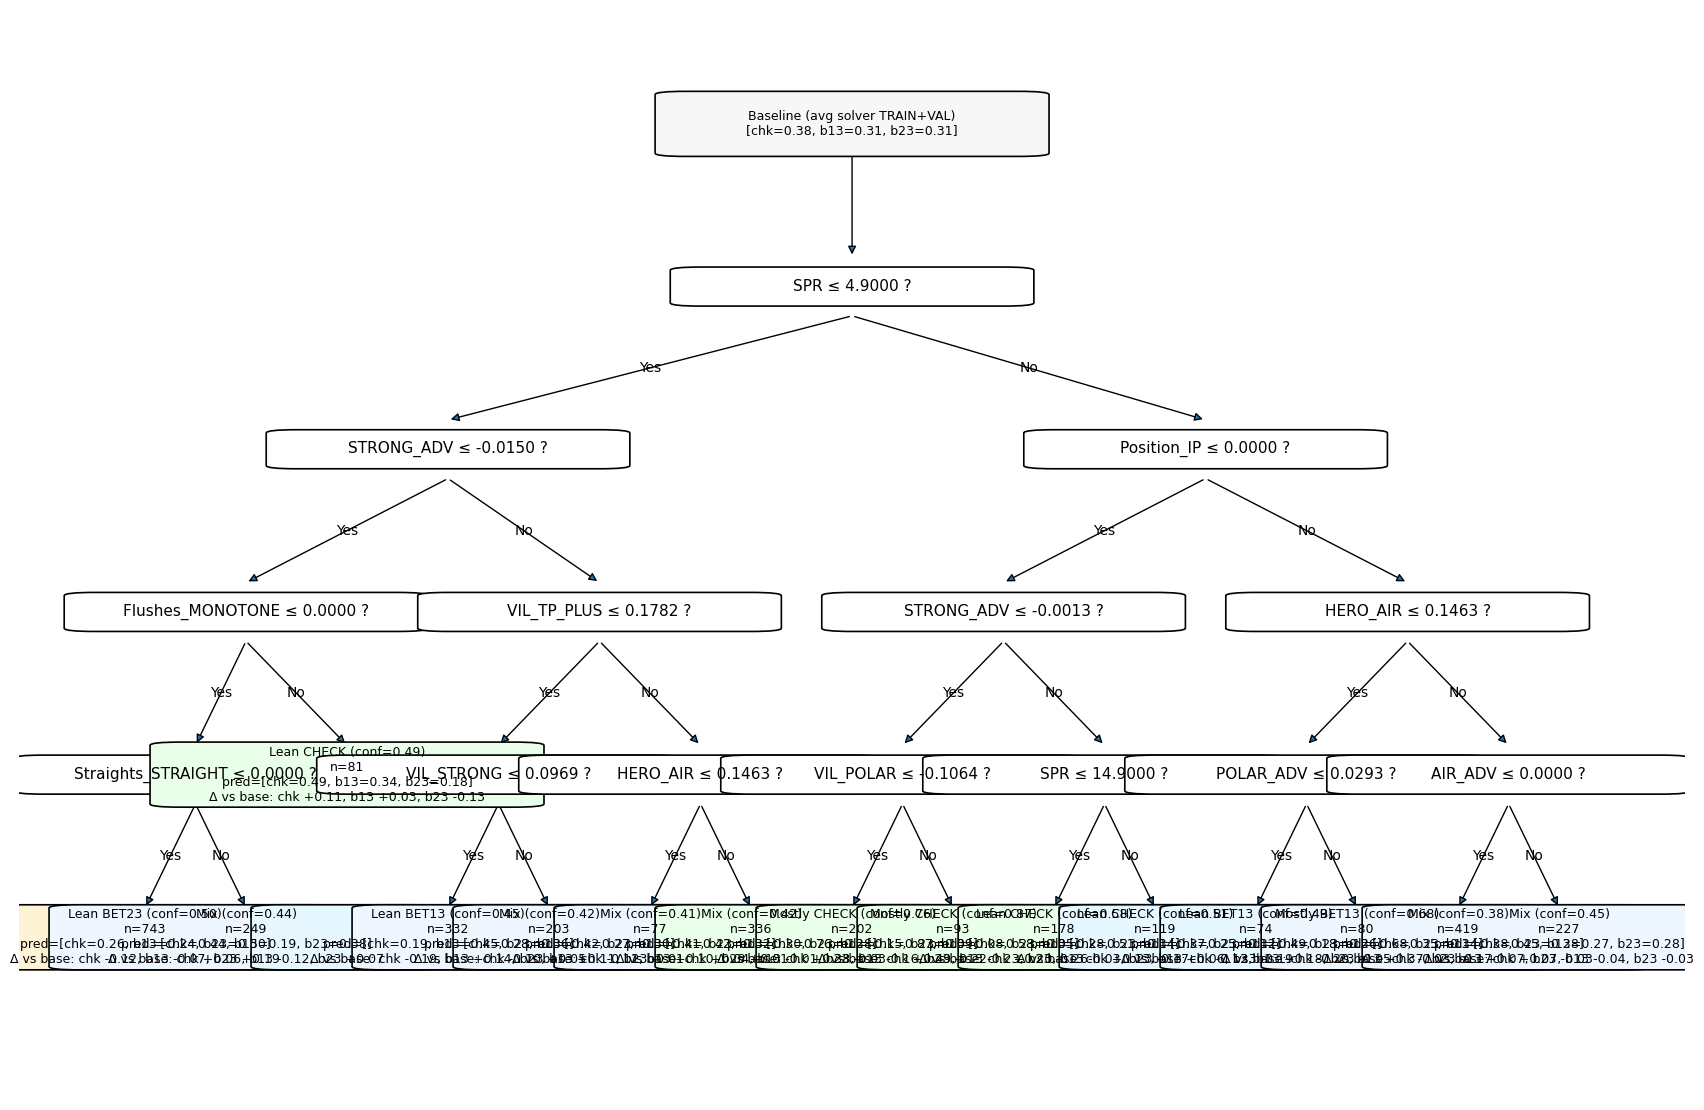

Saved: BornAgainTree_matplotlib.png


In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# -----------------------------
# 1) Helpers for formatting
# -----------------------------
BASELINE = [0.38, 0.31, 0.31]  # [check, b13, b23]

def fmt_pred(p):
    return f"[chk={p[0]:.2f}, b13={p[1]:.2f}, b23={p[2]:.2f}]"

def fmt_delta(p, baseline=BASELINE):
    d = [p[i] - baseline[i] for i in range(3)]
    return f"Δ vs base: chk {d[0]:+0.2f}, b13 {d[1]:+0.2f}, b23 {d[2]:+0.2f}"

def leaf_text(n, pred, title, conf):
    return (
        f"{title} (conf={conf:.2f})\n"
        f"n={n}\n"
        f"pred={fmt_pred(pred)}\n"
        f"{fmt_delta(pred)}"
    )

# -----------------------------
# 2) Tree representation
# -----------------------------
# Node schema:
#   Internal: {"type":"split","text": "...", "yes": <node>, "no": <node>}
#   Leaf:     {"type":"leaf", "text": "...", "fill": <color optional>}
#
# We'll keep the labels exactly like your rules.

tree = {
    "type": "split",
    "text": "SPR ≤ 4.9000 ?",
    "yes": {  # SPR <= 4.9
        "type": "split",
        "text": "STRONG_ADV ≤ -0.0150 ?",
        "yes": {
            "type": "split",
            "text": "Flushes_MONOTONE ≤ 0.0000 ?",
            "yes": {
                "type": "split",
                "text": "Straights_STRAIGHT ≤ 0.0000 ?",
                "yes": {"type":"leaf","text": leaf_text(743,[0.26,0.24,0.50],"Lean BET23",0.50), "fill":"#fff3d6"},
                "no":  {"type":"leaf","text": leaf_text(249,[0.44,0.19,0.38],"Mix",0.44),         "fill":"#eef6ff"},
            },
            "no": {"type":"leaf","text": leaf_text(81,[0.49,0.34,0.18],"Lean CHECK",0.49), "fill":"#eaffea"},
        },
        "no": {
            "type": "split",
            "text": "VIL_TP_PLUS ≤ 0.1782 ?",
            "yes": {
                "type": "split",
                "text": "VIL_STRONG ≤ 0.0969 ?",
                "yes": {"type":"leaf","text": leaf_text(332,[0.19,0.45,0.36],"Lean BET13",0.45), "fill":"#e6f7ff"},
                "no":  {"type":"leaf","text": leaf_text(203,[0.28,0.42,0.30],"Mix",0.42),        "fill":"#eef6ff"},
            },
            "no": {
                "type":"split",
                "text":"HERO_AIR ≤ 0.1463 ?",
                "yes":{"type":"leaf","text": leaf_text(77,[0.27,0.41,0.32],"Mix",0.41), "fill":"#eef6ff"},
                "no": {"type":"leaf","text": leaf_text(336,[0.42,0.30,0.28],"Mix",0.42),"fill":"#eef6ff"},
            }
        }
    },
    "no": {   # SPR > 4.9
        "type": "split",
        "text": "Position_IP ≤ 0.0000 ?",
        "yes": {
            "type":"split",
            "text":"STRONG_ADV ≤ -0.0013 ?",
            "yes": {
                "type":"split",
                "text":"VIL_POLAR ≤ -0.1064 ?",
                "yes":{"type":"leaf","text": leaf_text(202,[0.76,0.15,0.09],"Mostly CHECK",0.76), "fill":"#eaffea"},
                "no": {"type":"leaf","text": leaf_text(93,[0.87,0.08,0.05],"Mostly CHECK",0.87),  "fill":"#eaffea"},
            },
            "no": {
                "type":"split",
                "text":"SPR ≤ 14.9000 ?",
                "yes":{"type":"leaf","text": leaf_text(178,[0.58,0.28,0.14],"Lean CHECK",0.58), "fill":"#eaffea"},
                "no": {"type":"leaf","text": leaf_text(119,[0.51,0.37,0.12],"Lean CHECK",0.51), "fill":"#eaffea"},
            }
        },
        "no": {
            "type":"split",
            "text":"HERO_AIR ≤ 0.1463 ?",
            "yes":{
                "type":"split",
                "text":"POLAR_ADV ≤ 0.0293 ?",
                "yes":{"type":"leaf","text": leaf_text(74,[0.25,0.49,0.26],"Lean BET13",0.49), "fill":"#e6f7ff"},
                "no": {"type":"leaf","text": leaf_text(80,[0.18,0.68,0.14],"Mostly BET13",0.68),"fill":"#e6f7ff"},
            },
            "no":{
                "type":"split",
                "text":"AIR_ADV ≤ 0.0000 ?",
                "yes":{"type":"leaf","text": leaf_text(419,[0.35,0.38,0.28],"Mix",0.38), "fill":"#eef6ff"},
                "no": {"type":"leaf","text": leaf_text(227,[0.45,0.27,0.28],"Mix",0.45), "fill":"#eef6ff"},
            }
        }
    }
}

baseline_node = {"type":"leaf", "text": f"Baseline (avg solver TRAIN+VAL)\n{fmt_pred(BASELINE)}", "fill":"#f7f7f7"}
root = {"type":"split", "text":"START", "yes": tree, "no": None}  # wrapper so baseline connects cleanly

# -----------------------------
# 3) Layout (recursive)
# -----------------------------
def count_leaves(node):
    if node is None:
        return 0
    if node["type"] == "leaf":
        return 1
    return count_leaves(node.get("yes")) + count_leaves(node.get("no"))

def assign_positions(node, x0=0.0, x1=1.0, depth=0, pos=None, edges=None, node_ids=None, next_id=None):
    """
    Places nodes in [x0,x1] horizontally; y = -depth.
    Returns pos dict: id -> (x,y), labels dict, fills dict, edges list (parent, child, label).
    """
    if pos is None:
        pos, edges, node_ids, next_id = {}, [], {}, [0]

    # Create an ID for this node
    nid = node_ids.get(id(node))
    if nid is None:
        nid = f"N{next_id[0]}"
        node_ids[id(node)] = nid
        next_id[0] += 1

    # Compute x = center of segment; y based on depth
    x = (x0 + x1) / 2
    y = -depth
    pos[nid] = (x, y)

    # Recurse children
    if node["type"] == "split":
        yes = node.get("yes")
        no  = node.get("no")
        L = count_leaves(yes)
        R = count_leaves(no)
        total = max(L + R, 1)

        # split segment proportional to leaves
        mid = x0 + (x1 - x0) * (L / total)

        if yes is not None:
            cid, *_ = assign_positions(yes, x0, mid, depth+1, pos, edges, node_ids, next_id)
            edges.append((nid, cid, "Yes"))
        if no is not None:
            cid, *_ = assign_positions(no, mid, x1, depth+1, pos, edges, node_ids, next_id)
            edges.append((nid, cid, "No"))

    return nid, pos, edges, node_ids, next_id

# Build a top with baseline -> SPR split
top = {
    "type":"split",
    "text":"SPR ≤ 4.9000 ?",
    "yes": tree["yes"],
    "no": tree["no"]
}

# We'll manually connect baseline to top
_, pos, edges, node_ids, _ = assign_positions(top, 0.0, 1.0, depth=1)  # start at depth=1
# Add baseline node at depth=0 centered
pos["BASE"] = (0.5, 0)

# Map node IDs back to node objects so we can draw labels/fills
id_to_node = {v: k for k, v in node_ids.items()}  # (python_id)->nid reversed isn't useful; we'll rebuild by walking

def collect_nodes(node, out):
    nid = node_ids[id(node)]
    out[nid] = node
    if node["type"] == "split":
        if node.get("yes"): collect_nodes(node["yes"], out)
        if node.get("no"):  collect_nodes(node["no"], out)
    return out

nodes = collect_nodes(top, {})
nodes["BASE"] = baseline_node
edges.append(("BASE", node_ids[id(top)], ""))  # baseline to root split

# -----------------------------
# 4) Draw with matplotlib
# -----------------------------
def draw_tree(pos, edges, nodes, filename="BornAgainTree_matplotlib.png"):
    # figure size scales with depth and leaf count
    max_depth = int(max(-y for (_, y) in pos.values()))
    leaf_count = sum(1 for n in nodes.values() if n["type"] == "leaf")
    fig_w = max(12, leaf_count * 1.1)
    fig_h = max(6, (max_depth + 2) * 1.6)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")

    # draw edges first
    for parent, child, elabel in edges:
        x1, y1 = pos[parent]
        x2, y2 = pos[child]
        arrow = FancyArrowPatch(
            (x1, y1-0.18), (x2, y2+0.18),
            arrowstyle='-|>', mutation_scale=12,
            linewidth=1.0
        )
        ax.add_patch(arrow)
        if elabel:
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(mx, my, elabel, ha="center", va="center", fontsize=10)

    # draw nodes
    for nid, (x, y) in pos.items():
        node = nodes[nid]
        text = node["text"] if node["type"] == "leaf" else node["text"]
        fill = node.get("fill", "#ffffff")

        # box size heuristic: leaves have more text
        if node["type"] == "leaf":
            w, h = 0.22, 0.36
            fs = 9
        else:
            w, h = 0.20, 0.20
            fs = 11

        box = FancyBboxPatch(
            (x - w/2, y - h/2), w, h,
            boxstyle="round,pad=0.02,rounding_size=0.02",
            linewidth=1.2,
            facecolor=fill
        )
        ax.add_patch(box)
        ax.text(x, y, text, ha="center", va="center", fontsize=fs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-(max_depth + 1), 0.7)
    plt.tight_layout()
    plt.show()

    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")

draw_tree(pos, edges, nodes)
